In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from tqdm import tqdm
from prettytable import PrettyTable

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('../data/Close_correct.csv', index_col='date')
data.index = data.index.astype('datetime64').rename('date')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.225,22.355,9.3094,10.20,3.4959,9.955,26.66,11.898,9.4832,16.594,...,2.9896,21.90,19.270,12.832,17.76,7.7942,33.864,18.690,303.66,12.231
2010-01-05,20.858,22.589,9.1551,10.25,3.4577,10.022,26.57,11.954,9.5110,16.765,...,3.0673,20.91,19.466,13.234,17.88,7.8400,34.744,18.780,301.20,12.305
2010-01-06,20.612,22.637,9.0008,10.05,3.3339,10.217,26.92,11.594,9.5150,16.779,...,3.0390,20.80,19.570,13.442,16.68,7.8477,35.070,18.890,302.01,12.395
2010-01-07,20.683,22.269,9.0205,10.40,3.5341,10.115,26.50,11.695,9.7720,16.454,...,3.2582,21.65,19.613,13.120,17.52,7.8707,34.599,19.175,292.72,12.345
2010-01-08,21.085,22.192,8.9584,11.35,3.4197,10.149,26.19,11.485,9.8060,16.779,...,3.2016,21.25,19.570,13.106,17.52,7.8785,34.813,19.474,296.55,12.435


In [4]:
data_returns = pd.read_csv('../data/data_returns.csv', index_col='date')
data_returns.index = data_returns.index.astype('datetime64').rename('date')
data_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.031298,0.010467,-0.016575,0.004902,-0.010927,0.006730,-0.003376,0.004707,0.002931,0.010305,...,0.025990,-0.045205,0.010171,0.031328,0.006757,0.005876,0.025986,0.004815,-0.008101,0.006050
2010-01-06,-0.011794,0.002125,-0.016854,-0.019512,-0.035804,0.019457,0.013173,-0.030115,0.000421,0.000835,...,-0.009226,-0.005261,0.005343,0.015717,-0.067114,0.000982,0.009383,0.005857,0.002689,0.007314
2010-01-07,0.003445,-0.016257,0.002189,0.034826,0.060050,-0.009983,-0.015602,0.008711,0.027010,-0.019369,...,0.072129,0.040865,0.002197,-0.023955,0.050360,0.002931,-0.013430,0.015087,-0.030761,-0.004034
2010-01-08,0.019436,-0.003458,-0.006884,0.091346,-0.032370,0.003361,-0.011698,-0.017956,0.003479,0.019752,...,-0.017372,-0.018476,-0.002192,-0.001067,0.000000,0.000991,0.006185,0.015593,0.013084,0.007290


In [5]:
# numpy
def neutralize(alpha):
    return alpha - np.mean(alpha)

In [6]:
def normalize(alpha):
    return alpha / np.sum(np.abs(alpha))

In [7]:
def truncate(alpha, max_weight, coef):
    signs = (alpha / np.abs(alpha))
    alpha[np.abs(alpha) > max_weight * coef] = max_weight * coef
    alpha = alpha * signs
    return alpha

In [8]:
# pandas
def get_returns(data):
    return (data / data.shift(1)) - 1

In [9]:
def ranking(alpha):
    alpha = scipy.stats.rankdata(alpha, method='ordinal') / (len(alpha) - 1)
    return alpha

In [10]:
def cut_outliers(alpha, coef=0.01):
    alpha[alpha < np.quantile(alpha, coef)] = 0
    alpha[alpha > np.quantile(alpha, 1 - coef)] = 0
    return alpha

In [11]:
def cut_middle(alpha, coef=0.01):
    alpha[(alpha <= np.mean(alpha) + coef) & (alpha >= np.mean(alpha) - coef)] = 0
    return alpha

In [12]:
def turnover(alphas, option=0):
    turnover_days = abs(alphas.diff(periods=1)).sum(axis=1)
    if option == 1:
        return turnover_days
    return turnover_days.groupby(alphas.index.year).mean()

In [13]:
def get_sharpe_coef(days_pnl):
    ans = pd.DataFrame()
    ans['coef_sharpe'] = days_pnl.groupby(days_pnl.index.year).apply(lambda x : np.sqrt(len(x) - 1) * np.mean(x) / np.std(x))
    return ans

In [46]:
def get_drawdown_t_2(pnl_cum):
    pnl_cum_index =  pnl_cum.index
    pnl_cum = np.array(pnl_cum)
    max_drawdown = 0
    for i in range(2, len(pnl_cum)):
        for j in range(i + 1, len(pnl_cum)):
            if ((pnl_cum[i] - pnl_cum[j]) / pnl_cum[i] > max_drawdown) and (pnl_cum[i] - pnl_cum[j]) > 0:
                max_drawdown = (pnl_cum[i] - pnl_cum[j]) / pnl_cum[i]
                days_i = i
                days_j = j
    return max_drawdown, pnl_cum_index[days_i].strftime("%d.%m.%Y"), pnl_cum_index[days_j].strftime("%d.%m.%Y")

In [33]:
def get_drawdown_years(pnl_cum):
    return pnl_cum.groupby(pnl_cum.index.year).apply(lambda x: get_drawdown_t_2(x))

In [34]:
def get_pnl(data_returns, alpha, option=0):
    data_returns = data_returns.iloc[2:]
    pnl = alpha.reset_index(drop=True).mul(data_returns.reset_index(drop=True), axis=0).sum(axis=1)
    ans = pd.DataFrame()
    ans['pnl'] = pnl
    ans = ans.set_index(alpha.index).shift(2)
    if option == 1:
        return ans.set_index(alpha.index).groupby(alpha.index.year).sum()
    return ans

##### Alpha: reversion
$$ \alpha(d - 2) = -\left({close(d - 2) \over close(d - (2 + n))} - 1\right) $$
$$ return(d) = \left({close(d) \over close(d - 1)} - 1\right) $$
$$ pnl(d) = \alpha(d - 2) * return(d)$$


In [35]:
def algh_alpha_reversion(data, n=1):
    alpha = -(data / data.shift(n) - 1)
    alpha = alpha.T.apply(neutralize).apply(normalize).T
    return alpha

In [36]:
alpha_revers = algh_alpha_reversion(data, 1)
years_pnl_cum = get_pnl(data_returns, alpha_revers, 1)
days_pnl = get_pnl(data_returns, alpha_revers)

print('years pnl cum:', '\n', years_pnl_cum)
print('turnover:', turnover(alpha_revers))

years pnl cum: 
            pnl
date          
2010  0.130275
2011  0.093834
2012  0.102873
2013  0.063022
2014 -0.002831
turnover: date
2010    1.439132
2011    1.450142
2012    1.453622
2013    1.455579
2014    1.451279
dtype: float64


<Axes: xlabel='date'>

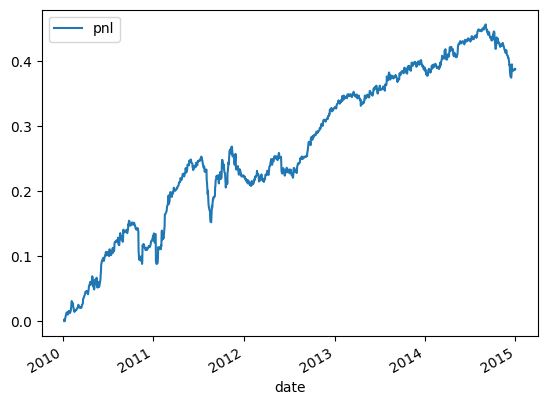

In [37]:
days_pnl.cumsum().plot()

test  
There seems to be a bias or some other error.  
Let's check that the program works correctly for the first day, when return is known.

In [38]:
print(data_returns[2:].iloc[1])
print('======================================================')
print(alpha_revers.iloc[1])
print('======================================================')
print(sum(data_returns[2:].iloc[1] * alpha_revers.iloc[1]))
print(days_pnl[days_pnl.index == '2010-01-07'])
sum(data_returns[2:].iloc[1] * alpha_revers.iloc[1])

0       0.003445
1      -0.016257
2       0.002189
3       0.034826
4       0.060050
          ...   
2431    0.002931
2432   -0.013430
2433    0.015087
2434   -0.030761
2435   -0.004034
Name: 2010-01-07 00:00:00, Length: 2436, dtype: float64
0      -0.000628
1      -0.000176
2       0.000411
3      -0.000055
4       0.000289
          ...   
2431   -0.000076
2432   -0.000513
2433   -0.000053
2434    0.000227
2435   -0.000080
Name: 2010-01-05 00:00:00, Length: 2436, dtype: float64
0.0031250205751006187
                 pnl
date                
2010-01-07  0.003125


0.0031250205751006187

In [39]:
def alpha_stats(data_returns, alpha):
    days_pnl = get_pnl(data_returns, alpha)['pnl']
    returns_table = pd.DataFrame()
    returns_table['years_pnl_cum'] = get_pnl(data_returns, alpha, 1)
    returns_table['turnover'] = turnover(alpha)
    returns_table['sharpe_coef'] = get_sharpe_coef(days_pnl)
    returns_table['drawdown'] = get_drawdown_years(days_pnl.cumsum())
    return returns_table

In [40]:
def generate_alphas_reversion_type(data, data_returns, max_n=1, cut_middle_coef=0, cut_outliers_coef=0):
    for n in range(1, max_n + 1):
        print('n =', n)
        print(alpha_stats(data_returns, algh_alpha_reversion(data, n)))
        print()
    
    print('CUT_OUTLIERS_COEF =', cut_outliers_coef)
    for n in range(1, max_n + 1):
        print('n =', n)
        print(alpha_stats(data_returns, algh_alpha_reversion(data, n).groupby(algh_alpha_reversion(data, n).index).apply(lambda x: cut_outliers(x, cut_outliers_coef))))
        print()
    

In [47]:
generate_alphas_reversion_type(data, data_returns, max_n=3, cut_outliers_coef=0.01)

n = 1
      years_pnl_cum  turnover  sharpe_coef  \
date                                         
2010       0.130275  1.439132     1.912082   
2011       0.093834  1.450142     0.957710   
2012       0.102873  1.453622     2.128993   
2013       0.063022  1.455579     1.453953   
2014      -0.002831  1.451279    -0.055071   

                                           drawdown  
date                                                 
2010   (0.8230509604494961, 07.01.2010, 08.01.2010)  
2011  (0.39901716887675726, 13.07.2011, 22.08.2011)  
2012  (0.14783859531609309, 21.05.2012, 17.07.2012)  
2013  (0.06117006833092671, 19.03.2013, 17.04.2013)  
2014   (0.1795652375581222, 03.09.2014, 15.12.2014)  

n = 2
      years_pnl_cum  turnover  sharpe_coef  \
date                                         
2010       0.128244  1.008131     2.127506   
2011       0.153952  1.016436     1.656729   
2012       0.121267  1.018992     2.791367   
2013       0.064224  1.017035     1.371093   
2014      